In [84]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns

from scipy.stats import binned_statistic_2d

%config InlineBackend.figure_format = 'retina'
#CMAP = cm.get_cmap('RdBu')
CMAP = cm.get_cmap('twilight')
REF_RESULTS = pd.read_csv('reference_results.txt')

## Auxiliar Functions

In [85]:
def bin_values(bins, x_values, y_values, y_err):
    """Values are binned using the given bins.
    
    Parameters
    ==========
    bins: array
        array of bins
    x_values: array
        array of x-axis values
    y_values: array
        array of y-axis values
    y_err: array
        array of y-axis errors
        
    Returns
    =======
    delta_bins, std_bins, err_bins: arrays
        Arrays of
    """
    
    digitized = np.digitize(x_values, bins)
    delta_bins, std_bins, err_bins = [], [], []
    
    for i in range(1, len(bins)):
        if len(y_values[digitized == i])>0:
            y = y_values[digitized == i]
            w = 1/y_err[digitized == i]**2
            
            wmean = np.average(y, weights=w)
            werr = np.sqrt(np.sum(w*(y- wmean)**2)/((len(w)-1)*np.sum(w)))
            wstd = np.sqrt(np.average((y - wmean)**2, weights=w))
            
            delta_bins.append(wmean)
            std_bins.append(wstd)
            err_bins.append(werr)
        else:
            delta_bins.append(np.nan)
            std_bins.append(np.nan)
            err_bins.append(np.nan)

    delta_bins, std_bins, err_bins = np.array(delta_bins), np.array(std_bins), np.array(err_bins)
    
    return delta_bins, std_bins, err_bins

def flatten_array(array):
    """Flattens an array/list with multiple 
    sub-arrays/lists with different sizes.
    
    Parameters
    ==========
    array: list-like
        List/array to flatten.
        
    Returns
    =======
    flat_array: list-like
        Flatten array.
    """
    flat_array = np.array([item for sublist in array 
                                  for item in sublist])
    
    return flat_array

def get_extent(ret):
    """Extracts the extent from the results of
    `scipy.stats.binned_statistic_2d()` to plot
    2D binned data.
    
    Parameters
    ==========
    ret: `scipy.stats.binned_statistic_2d()` results
    
    Returns
    =======
    extent: extent to plot 2D binned data.
    """
    extent = [ret[1][0], ret[1][-1], ret[2][0], ret[2][-1]]
    
    return extent

def extract_parameters(sn_name, param, ref_bands, n_epochs):
    """Extracts the parameters of a SN (e.g., Jmax and 
    metrics) for the diagnosis plots.
    
    Parameters
    ==========
    sn_name: str
        SN name (e.g., SN2004eo).
    params: str
        SN parameter (e.g., Jmax, Tmax, st).
    ref_bands: str
        Bands used for the reference fits. E.g., `AllBands`,
        'grJH', 'gr' and 'gp' (gaussian process).
    n_epochs: int
        Number of epochs for the combinatories of the 
        simulations.
        
    Returns
    =======
    residuals: array
        Parameter residuals between the reference fits and simulations 
        fits.
    yerr: array
        Uncertainty of the parameter.
    m1, m2, m3: arrays
        Metrics used.
    """
    
    # ref
    ref_df = REF_RESULTS[REF_RESULTS.name==sn_name]
    y_ref = ref_df[f'{param}_{ref_bands}'].values[0]

    # sim
    sim_file = os.path.join('sim_fits', 
                            sn_name, 
                            (f'{sn_name}_{n_epochs}'
                             'epochs_results.csv'))
    sim_df = pd.read_csv(sim_file)
    y = sim_df[param].values
    yerr = sim_df[param+'_err'].values     

    residuals = y-y_ref
    
    m1 = sim_df.m1.values
    m2 = sim_df.m2.values
    m3 = sim_df.m3.values

    return residuals, yerr, m1, m2, m3

## Diagnosis Plots functions

In [93]:
def plot_m1(param, ref_bands):
    """Diagnosis plots with for simulations with 3 epochs.
    
    Parameters
    ==========
    sn_name: str
        SN name (e.g., SN2004eo).
    params: str
        SN parameter (e.g., Jmax, Tmax, st).
    ref_bands: str
        Bands used for the reference fits. E.g., `AllBands`,
        'grJH', 'gr' and 'gp' (gaussian process).
    binned: bool, default `True`
        If `True`, plots the 2D binned version.
    """
    # colour for outliers
    colour_palette  = sns.color_palette('tab10')[1:]
    counter = (i for i in range(len(colour_palette)))
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    params_dict = {'residuals':[], 'yerr':[], 'm1':[]}
    for sn_name in REF_RESULTS.name:
        try:
            parameters = extract_parameters(sn_name, param, 
                                            ref_bands, 1)
            residuals, yerr, m1, _, _ = parameters
            
            params_dict['m1'].append(m1)
            params_dict['yerr'].append(yerr)
            params_dict['residuals'].append(residuals)
            
            #detect outliers
            if np.any(np.abs(residuals)>0.5):
                color = colour_palette[next(counter)]
                label = sn_name
            else:
                color = 'b'
                label = None
            
            # plot
            ax.errorbar(m1, residuals, yerr=yerr, 
                        fmt='o', color=color, alpha=0.6,
                        mec='k', label=label)
        except:
            pass

    # fatten arrays
    for key, values in params_dict.items():
            params_dict[key] = flatten_array(values)

    # plot bins
    min_val = np.round(params_dict['m1'], 0).min()
    max_val = np.round(params_dict['m1']+1, 0).max()
    step = 2  # days
    bins = np.arange(min_val, max_val, step)
    delta_bins, std_bins, err_bins = bin_values(bins, 
                                                params_dict['m1'], 
                                                params_dict['residuals'], 
                                                params_dict['yerr'])
    
    ax.errorbar(bins[:-1], delta_bins, err_bins, 
                color='red', zorder=18, ms=8, mec='k', fmt='h', 
                ecolor='red', capsize=8, capthick=2, elinewidth=2.5)
    
    ax.axhline(0, color='k', ls='--')
    ax.set_xlabel('Phase of the closest NIR epoch to Tmax', fontsize=16)
    ax.set_ylabel(f'{param} residuals (mag)', fontsize=16)
    ax.tick_params(labelsize=16)
    if next(counter)!=0:
        ax.legend(fontsize=12, ncol=2)
    plt.show()
    
def plot_m2(param, ref_bands, binned=True):
    """Diagnosis plots with for simulations with 2 epochs.
    
    Parameters
    ==========
    sn_name: str
        SN name (e.g., SN2004eo).
    params: str
        SN parameter (e.g., Jmax, Tmax, st).
    ref_bands: str
        Bands used for the reference fits. E.g., `AllBands`,
        'grJH', 'gr' and 'gp' (gaussian process).
    binned: bool, default `True`
        If `True`, plots the 2D binned version.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # colour bar
    norm = colors.Normalize(vmin=-0.11, vmax=0.11)
    s_m = plt.cm.ScalarMappable(cmap=CMAP, norm=norm)
    s_m.set_array([])
    
    params_dict = {'residuals':[], 'm1':[], 'm2':[]}
    for sn_name in REF_RESULTS.name:
        try:
            parameters = extract_parameters(sn_name, param, 
                                            ref_bands, 2)
            residuals, _, m1, m2, _ = parameters

            params_dict['m1'].append(m1)
            params_dict['m2'].append(m2)
            params_dict['residuals'].append(residuals)
            
            if not binned:
                s, marker, alpha = 50, 'o', 0.6
                ax.scatter(m1, m2, s=s, marker=marker, 
                             edgecolors='k', alpha=alpha,
                             c=s_m.to_rgba(residual))
        except:
            pass
        
    if binned:
        # flatten arrays
        for key, values in params_dict.items():
            params_dict[key] = flatten_array(values)
        
        ret = binned_statistic_2d(params_dict['m1'], params_dict['m2'], 
                                  params_dict['residuals'], 
                                  statistic='mean', bins = [20, 40])

        extent = get_extent(ret)
        ax.imshow(ret[0].T, cmap=CMAP, extent=extent, norm=norm,
                  interpolation='nearest', origin='lower', aspect='auto')

    ax.set_xlabel('Phase of the closest NIR epoch to Tmax', fontsize=16)
    ax.set_ylabel(f'Mean phase of the NIR epochs (days)', fontsize=16)
    
    # finish colour bar
    cbar = plt.colorbar(s_m, ax=ax)
    cbar.set_label(f'{param} residuals (mag)', rotation=270, fontsize=16)
    cbar.ax.get_yaxis().labelpad = 16
    cbar.ax.tick_params(labelsize=16)
    
    ax.tick_params(labelsize=16)
    plt.show()
    
def plot_m3(param, ref_bands, binned=True):
    """Diagnosis plots with for simulations with 3 epochs.
    
    Parameters
    ==========
    sn_name: str
        SN name (e.g., SN2004eo).
    params: str
        SN parameter (e.g., Jmax, Tmax, st).
    ref_bands: str
        Bands used for the reference fits. E.g., `AllBands`,
        'grJH', 'gr' and 'gp' (gaussian process).
    binned: bool, default `True`
        If `True`, plots the 2D binned version.
    """
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), 
                           gridspec_kw={'hspace':0, 
                                        'wspace':0})
    
    # colour bar
    norm = colors.Normalize(vmin=-0.11, vmax=0.11)
    s_m = plt.cm.ScalarMappable(cmap=CMAP, norm=norm)
    s_m.set_array([])
    
    params_dict = {'residuals':[], 'm1':[], 'm2':[], 'm3':[]}
    for sn_name in REF_RESULTS.name:
        try:
            parameters = extract_parameters(sn_name, param, 
                                            ref_bands, 3)
            residuals, _, m1, m2, m3 = parameters

            params_dict['m1'].append(m1)
            params_dict['m2'].append(m2)
            params_dict['m3'].append(m3)
            params_dict['residuals'].append(residuals)
            
            if not binned:
                s, marker, alpha = 50, 'o', 0.6
                ax[0, 0].scatter(m1, m2, s=s, marker=marker, 
                                 edgecolors='k', alpha=alpha,
                                 c=s_m.to_rgba(residual))
                ax[1, 0].scatter(m1, m3, s=s, marker=marker,
                                 edgecolors='k', alpha=alpha,
                                 c=s_m.to_rgba(residual))
                ax[1, 1].scatter(m2, m3, s=s, marker=marker, 
                                 edgecolors='k', alpha=alpha,
                                 c=s_m.to_rgba(residual))
        except:
            pass
    
    if binned:
        # flatten arrays
        for key, values in params_dict.items():
            params_dict[key] = flatten_array(values)
        
        ret12 = binned_statistic_2d(params_dict['m1'], params_dict['m2'], 
                                    params_dict['residuals'], 
                                    statistic='mean', bins = [20, 40])
        ret13 = binned_statistic_2d(params_dict['m1'], params_dict['m3'], 
                                    params_dict['residuals'], 
                                    statistic='mean', bins = [20, 40])
        ret23 = binned_statistic_2d(params_dict['m2'], params_dict['m3'], 
                                    params_dict['residuals'], 
                                    statistic='mean', bins = [40, 40])

        extent12 = get_extent(ret12)
        extent13 = get_extent(ret13)
        extent23 = get_extent(ret23)
        ax[0,0].imshow(ret12[0].T, cmap=CMAP, extent=extent12, norm=norm,
                  interpolation='nearest', origin='lower', aspect='auto')
        ax[1,0].imshow(ret13[0].T, cmap=CMAP, extent=extent13,norm=norm,
                  interpolation='nearest', origin='lower', aspect='auto')
        ax[1,1].imshow(ret23[0].T, cmap=CMAP, extent=extent23, norm=norm, 
                  interpolation='nearest', origin='lower', aspect='auto')

    ax[0,0].set_xlabel('Phase of the closest\nNIR epoch to Tmax', fontsize=16)
    ax[0,0].set_ylabel(f'Mean phase of the\nNIR epochs (days)', fontsize=16)
    ax[1,0].set_xlabel('Phase of the closest\nNIR epoch to Tmax', fontsize=16)
    ax[1,0].set_ylabel(f'Difference between furthest\nNIR epochs (days)', fontsize=16)
    ax[1,1].set_xlabel('Mean phase of the\nNIR epochs (days)', fontsize=16)
    ax[1,1].axes.yaxis.set_visible(False)
    
    # finish colour bar
    ax[0,1].set_aspect(6)
    cbar = plt.colorbar(s_m, cax=ax[0, 1])
    cbar.set_label(f'{param} residuals (mag)', rotation=270, fontsize=16)
    cbar.ax.get_yaxis().labelpad = 16
    cbar.ax.tick_params(labelsize=16)
    
    for axes in ax:
        for subaxis in axes:
            subaxis.tick_params(labelsize=16)
    plt.show()
    
def master_plot(param, ref_bands, n_epochs, binned=True):
    """Plots any of the diagnosis plots.
    
    Parameters
    ==========
    params: str
        SN parameter (e.g., Jmax, Tmax, st).
    ref_bands: str
        Bands used for the reference fits. E.g., `AllBands`,
        'grJH', 'gr' and 'gp' (gaussian process).
    n_epochs: int
        Number of epochs for the combinatories of the 
        simulations.
    binned: bool, default `True`
        If `True`, plots the 2D binned version when 
        `n_epochs` is 2 or 3.
    """
    
    assert 1<=n_epochs<=3, '`n_epochs` must be 1, 2 or 3'
    
    if n_epochs==1:
        plot_m1(param, ref_bands)
    elif n_epochs==2:
        plot_m2(param, ref_bands)
    elif n_epochs==3:
        plot_m3(param, ref_bands)

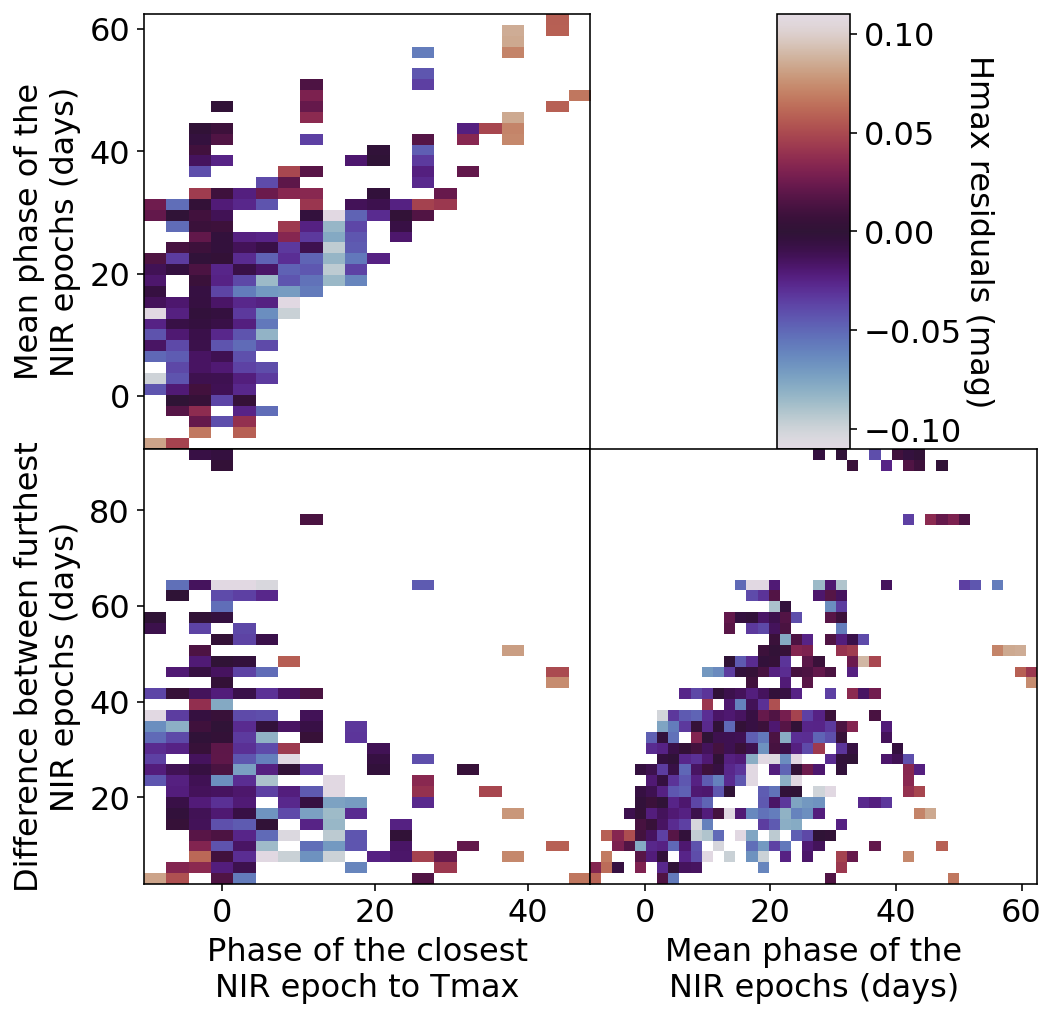

In [95]:
master_plot('Hmax', ref_bands, 3)